# Pipeline Output Summary — Counts & Rates

**Purpose:** Show what the oracle + alignment pipeline produced across all test
cases and optimization levels. Three views:

1. **Oracle verdict distribution** — what fraction of DWARF functions the oracle
   accepted, warned, or rejected (before alignment ever runs).
2. **Alignment verdict distribution** — of all functions (including non-targets),
   what fraction ended up as MATCH / AMBIGUOUS / NO_MATCH / NON_TARGET.
3. **Summary table** — per (test_case, opt) breakdown with yield rate,
   mean overlap, mean quality weight.

All aggregate counts come from `compute_verdict_rates(ds.reports)`.  
Per-pair metrics come from `enrich_pairs(ds.pairs)`.

In [1]:
## ── Imports & Style ──────────────────────────────────────────────────────────

from pathlib import Path
import sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sys.path.insert(0, str(Path("../..").resolve()))

from data import (
    load_dataset, enrich_pairs, compute_verdict_rates,
    AlignmentVerdict, OracleVerdict,
)

warnings.filterwarnings("ignore", category=FutureWarning)

# ── Thesis style ──────────────────────────────────────────────────────────────
PALETTE_VERDICT = {
    AlignmentVerdict.MATCH.value:      "#66c2a5",
    AlignmentVerdict.AMBIGUOUS.value:   "#fc8d62",
    AlignmentVerdict.NO_MATCH.value:    "#e78ac3",
    AlignmentVerdict.NON_TARGET.value:  "#8da0cb",
}
PALETTE_ORACLE = {
    OracleVerdict.ACCEPT.value: "#66c2a5",
    OracleVerdict.REJECT.value: "#e78ac3",
    OracleVerdict.WARN.value:   "#fc8d62",
}
OPT_COLORS = {"O0": "#4daf4a", "O1": "#377eb8", "O2": "#ff7f00", "O3": "#e41a1c"}

THESIS_RC = {
    "font.family": "serif", "font.size": 10,
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "legend.fontsize": 9, "figure.dpi": 120,
    "savefig.dpi": 300, "savefig.bbox": "tight",
    "figure.figsize": (7, 4.5),
    "axes.spines.top": False, "axes.spines.right": False,
}
plt.rcParams.update(THESIS_RC)
sns.set_context("paper", rc=THESIS_RC)

FIG_DIR = Path("../../figures/oracle_analysis")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name: str, fig=None):
    fig = fig or plt.gcf()
    for ext in ("pdf", "png"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")
    print(f"  → saved {FIG_DIR / name}.{{pdf,png}}")

print("✓ imports & style ready")

✓ imports & style ready


In [2]:
## ── Load Data ────────────────────────────────────────────────────────────────

SELECTED_TESTS: list[str] | None = None
OPT_LEVELS = ["O0", "O1", "O2", "O3"]
VARIANT = "debug"

ds = load_dataset(
    Path("../../docker/local-files/artifacts/synthetic"),
    test_cases=SELECTED_TESTS,
    opt_levels=OPT_LEVELS,
    variant=VARIANT,
)

df_pairs  = enrich_pairs(ds.pairs)
df_report = compute_verdict_rates(ds.reports)
tests     = ds.test_cases

print(f"✓ {len(tests)} test cases, {len(df_pairs)} pairs, {len(df_report)} report rows")

✓ 12 test cases, 594 pairs, 48 report rows


---
## Plot 1 — Oracle Verdict Distribution

**What it shows:** For each optimization level, the percentage of DWARF functions
that the oracle classified as ACCEPT, WARN, or REJECT.

**How it's computed:** `compute_verdict_rates` divides each oracle count by
`oracle_total` and multiplies by 100. Here we aggregate across all test cases:

```
accept_rate = oracle_accept / oracle_total × 100
warn_rate   = oracle_warn   / oracle_total × 100
reject_rate = oracle_reject / oracle_total × 100
```

The raw counts (`oracle_accept`, `oracle_reject`, `oracle_warn`) come directly
from `oracle_report.json` per (test_case, opt). We sum them across test cases,
then compute the percentage for each opt level.

**Why it matters:** This shows the pre-alignment impact of optimization — how
many functions the compiler makes *untargetable* before alignment even runs.

  → saved ..\..\figures\oracle_analysis\01_oracle_verdict_degradation_pct.{pdf,png}


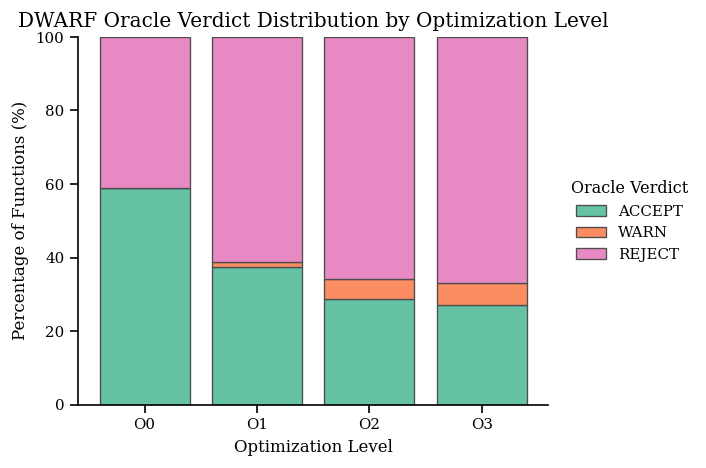

In [3]:
## ── Plot 1: Oracle Verdict Distribution (Percentage Stacked) ────────────────

oracle_melt = df_report.melt(
    id_vars=["test_case", "opt"],
    value_vars=["oracle_accept", "oracle_reject", "oracle_warn"],
    var_name="verdict_raw", value_name="count",
)
oracle_melt["verdict"] = (
    oracle_melt["verdict_raw"].str.replace("oracle_", "").str.upper()
)

oracle_agg = oracle_melt.groupby(["opt", "verdict"], as_index=False)["count"].sum()
oracle_agg["percent"] = (
    oracle_agg["count"] / oracle_agg.groupby("opt")["count"].transform("sum")
) * 100

oracle_pivot = (
    oracle_agg.pivot(index="opt", columns="verdict", values="percent").fillna(0)
)

v_order = [OracleVerdict.ACCEPT.value, OracleVerdict.WARN.value, OracleVerdict.REJECT.value]
oracle_pivot = oracle_pivot[v_order]

fig, ax = plt.subplots(figsize=(6, 4))
bottom = np.zeros(len(oracle_pivot))
for verdict in v_order:
    vals = oracle_pivot[verdict].values
    ax.bar(oracle_pivot.index, vals, bottom=bottom,
           label=verdict, color=PALETTE_ORACLE[verdict], edgecolor="0.3")
    bottom += vals

ax.set_ylabel("Percentage of Functions (%)")
ax.set_xlabel("Optimization Level")
ax.set_title("DWARF Oracle Verdict Distribution by Optimization Level")
ax.set_ylim(0, 100)
ax.legend(title="Oracle Verdict", frameon=False,
          loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
save_fig("01_oracle_verdict_degradation_pct")
plt.show()

---
## Plot 2 — Alignment Verdict Distribution

**What it shows:** For each optimization level, the percentage of *all* functions
(including oracle-rejected ones) that ended up in each alignment category.

**How it's computed:** `compute_verdict_rates` computes:

```
total = match + ambiguous + no_match + non_target
match_rate      = match      / total × 100
ambiguous_rate  = ambiguous  / total × 100
no_match_rate   = no_match   / total × 100
non_target_rate = non_target / total × 100
```

Here we again aggregate the raw counts across test cases first, then compute
percentages per opt level.

**Why it matters:** Shows the headline result — how much *usable ground truth*
(MATCH) we retain at each optimization level.

  → saved ..\..\figures\oracle_analysis\02_alignment_outcome_shift_pct.{pdf,png}


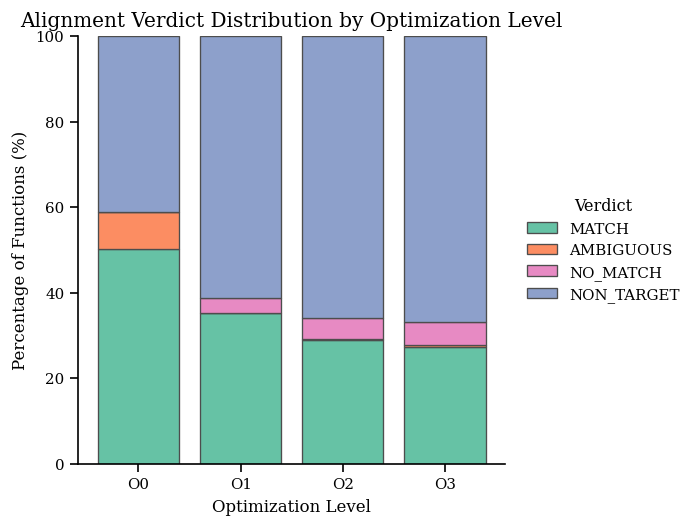

In [4]:
## ── Plot 2: Alignment Verdict Distribution (Percentage Stacked) ──────────────

verdict_cats = [
    AlignmentVerdict.MATCH.value,
    AlignmentVerdict.AMBIGUOUS.value,
    AlignmentVerdict.NO_MATCH.value,
    AlignmentVerdict.NON_TARGET.value,
]

align_melt = df_report.melt(
    id_vars=["test_case", "opt"],
    value_vars=["match", "ambiguous", "no_match", "non_target"],
    var_name="verdict_raw", value_name="count",
)
align_melt["verdict"] = align_melt["verdict_raw"].str.upper()

align_agg = align_melt.groupby(["opt", "verdict"], as_index=False)["count"].sum()
align_agg["percent"] = (
    align_agg["count"] / align_agg.groupby("opt")["count"].transform("sum")
) * 100

align_pivot = (
    align_agg.pivot(index="opt", columns="verdict", values="percent").fillna(0)
)[verdict_cats]

fig, ax = plt.subplots(figsize=(7, 4.5))
bottom = np.zeros(len(align_pivot))
for v in verdict_cats:
    vals = align_pivot[v].values
    ax.bar(align_pivot.index, vals, bottom=bottom,
           label=v, color=PALETTE_VERDICT[v], edgecolor="0.3")
    bottom += vals

ax.set_xlabel("Optimization Level")
ax.set_ylabel("Percentage of Functions (%)")
ax.set_title("Alignment Verdict Distribution by Optimization Level")
ax.set_ylim(0, 100)
ax.legend(title="Verdict", frameon=False,
          loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])  # type: ignore

save_fig("02_alignment_outcome_shift_pct")
plt.show()

---
## Summary Table

Per (test_case, opt) breakdown showing:

- **yield_rate** = `n_match / n_pairs × 100` — what percentage of aligned pairs
  achieved a clean MATCH.  Denominator is only functions that *entered* alignment
  (oracle ACCEPT + WARN).
- **total_yield** = `n_match / (n_pairs + n_non_target) × 100` — end-to-end
  recovery rate including oracle-rejected functions.  This is the "true" rate
  of usable ground truth relative to all DWARF functions discovered in the
  binary.  Functions that never enter alignment are those rejected by the oracle
  (see Plot 1 above for the breakdown of oracle reject reasons).
- **mean_overlap** = average `overlap_ratio` across all pairs in that group.
- **mean_quality_weight** = average `quality_weight` across all pairs.
  `quality_weight = overlap_ratio / n_candidates` for MATCH pairs, 0 otherwise.
  This captures both overlap fidelity and structural ambiguity in one number.
- **median_gap** = median gap count (DWARF line rows not attributable to best candidate).
- **n_non_target** = oracle-rejected functions that never entered alignment.

In [5]:
## ── Summary Table ────────────────────────────────────────────────────────────

pair_summary = df_pairs.groupby(["test_case", "opt"]).agg(
    n_pairs=("verdict", "size"),
    n_match=("verdict", lambda x: (x == AlignmentVerdict.MATCH.value).sum()),
    n_ambiguous=("verdict", lambda x: (x == AlignmentVerdict.AMBIGUOUS.value).sum()),
    n_no_match=("verdict", lambda x: (x == AlignmentVerdict.NO_MATCH.value).sum()),
    mean_overlap=("overlap_ratio", "mean"),
    mean_quality_weight=("quality_weight", "mean"),
    median_gap=("gap_count", "median"),
).reset_index()

pair_summary["yield_rate"] = (
    pair_summary["n_match"] / pair_summary["n_pairs"] * 100
).round(1)
pair_summary["mean_overlap"] = pair_summary["mean_overlap"].round(3)
pair_summary["mean_quality_weight"] = pair_summary["mean_quality_weight"].round(3)

# Merge non-target counts
nt_counts = ds.non_targets.groupby(["test_case", "opt"]).size().reset_index(name="n_non_target")
pair_summary = pair_summary.merge(nt_counts, on=["test_case", "opt"], how="left").fillna(0)
pair_summary["n_non_target"] = pair_summary["n_non_target"].astype(int)

# End-to-end recovery rate (includes oracle-rejected non-targets in denominator)
pair_summary["total_yield"] = (
    pair_summary["n_match"]
    / (pair_summary["n_pairs"] + pair_summary["n_non_target"]).replace(0, 1)
    * 100
).round(1)

display_cols = [
    "test_case", "opt", "n_pairs", "n_match", "n_ambiguous", "n_no_match",
    "n_non_target", "yield_rate", "total_yield",
    "mean_overlap", "mean_quality_weight", "median_gap",
]

styled = (
    pair_summary[display_cols]
    .style
    .format({"yield_rate": "{:.1f}%", "total_yield": "{:.1f}%",
             "mean_overlap": "{:.3f}",
             "mean_quality_weight": "{:.3f}", "median_gap": "{:.0f}"})
    .set_caption("Summary: Alignment Quality per Test Case and Optimization Level")
    .background_gradient(subset=["yield_rate"], cmap="RdYlGn", vmin=0, vmax=100)
    .background_gradient(subset=["total_yield"], cmap="RdYlGn", vmin=0, vmax=100)
    .background_gradient(subset=["mean_quality_weight"], cmap="RdYlGn", vmin=0, vmax=1)
)
display(styled)

# Aggregate summary
print("\n── Aggregate across all test cases ──")
for opt in OPT_LEVELS:
    sub = pair_summary[pair_summary["opt"] == opt]
    total_pairs = sub["n_pairs"].sum()
    total_match = sub["n_match"].sum()
    total_nt = sub["n_non_target"].sum()
    avg_w = df_pairs[df_pairs["opt"] == opt]["quality_weight"].mean()
    total_denom = total_pairs + total_nt
    print(f"  {opt}: {total_match}/{total_pairs} matched "
          f"({total_match/total_pairs*100:.1f}% aligned, "
          f"{total_match/total_denom*100:.1f}% end-to-end), "
          f"{total_nt} non-targets, mean quality_weight={avg_w:.3f}")

,test_case,opt,n_pairs,n_match,n_ambiguous,n_no_match,n_non_target,yield_rate,total_yield,mean_overlap,mean_quality_weight,median_gap
0,t01_crossfile_calls,O0,13,11,2,0,10,84.6%,47.8%,1.000,0.846,0
1,t01_crossfile_calls,O1,9,9,0,0,14,100.0%,39.1%,0.951,0.821,0
2,t01_crossfile_calls,O2,9,7,0,2,16,77.8%,28.0%,0.909,0.778,0
3,t01_crossfile_calls,O3,9,8,0,1,16,88.9%,32.0%,0.942,0.798,0
4,t02_shared_header_macros,O0,18,9,9,0,5,50.0%,39.1%,1.000,0.500,0
5,t02_shared_header_macros,O1,4,1,0,3,20,25.0%,4.2%,0.594,0.250,26
6,t02_shared_header_macros,O2,3,0,0,3,21,0.0%,0.0%,0.430,0.000,71
7,t02_shared_header_macros,O3,3,0,0,3,21,0.0%,0.0%,0.453,0.000,59
8,t03_header_dominant,O0,18,4,14,0,8,22.2%,15.4%,1.038,0.222,0
9,t03_header_dominant,O1,3,1,0,2,28,33.3%,3.2%,0.494,0.333,97



── Aggregate across all test cases ──
  O0: 166/195 matched (85.1% aligned, 50.2% end-to-end), 136 non-targets, mean quality_weight=0.851
  O1: 128/141 matched (90.8% aligned, 35.2% end-to-end), 223 non-targets, mean quality_weight=0.870
  O2: 110/130 matched (84.6% aligned, 28.9% end-to-end), 251 non-targets, mean quality_weight=0.791
  O3: 105/128 matched (82.0% aligned, 27.2% end-to-end), 258 non-targets, mean quality_weight=0.760
